In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.initializers import GlorotUniform
import random as python_random

np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

2024-05-23 00:55:37.448544: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 00:55:37.469208: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 00:55:37.469225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 00:55:37.469768: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 00:55:37.473340: I tensorflow/core/platform/cpu_feature_guar

### 1. Carga de datos

In [2]:
def load_data(filepath):
    return pd.read_csv(filepath, parse_dates=['Date'])

### 2. Division y tratamiento de datos

In [3]:
def create_sequences(data, target, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

In [4]:
def modify_data(data):
    result = None
    # print(data)

    # copy LMCADY_acu_5d_log into a new column ACU_5D and shift it by 5 days
    data['ACU_5D'] = data['LMCADY_acu_5d_log']
    data['ACU_5D'] = data['ACU_5D'].shift(5)
    
    # data['ACU_5D_alt'] = data['LMCADY'].rolling(window=5).sum()
    data['ACU_4D'] = data['LMCADY'].rolling(window=4).sum()
    data['ACU_3D'] = data['LMCADY'].rolling(window=3).sum()
    data['ACU_2D'] = data['LMCADY'].rolling(window=2).sum()

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)

    result = data
    # print(result.head(10))
    return result

In [5]:
def prepare_data(df, target_column, n_steps, feature_list):
    df = modify_data(df)

    features = df.drop(columns=['LMCADY_std_5d_log', 'Date'])
    features.to_csv('./output/features_and_target_cnn.csv', index=False)
    features = features.drop(columns=[target_column])
    features = features[feature_list]
    print(features.head(5))  # Mostrar las primeras 5 filas de las características

    target = df[target_column]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    X, y = create_sequences(features_scaled, target, n_steps)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
    return X_train, X_test, y_train, y_test

In [6]:
# df = load_data("./input/copper_log_returns_5d_final.csv")
# # df

In [7]:
# Preparación de los datos
# X_train, X_test, y_train, y_test = prepare_data(df, 'LMCADY_acu_5d_log', 10)

In [8]:
# df = load_data("./input/copper_log_returns_5d_final.csv")
# # print(f"\n{i}) Testing with n_steps={n_steps}, batch_size={batch_size}, epochs={epochs}, filters={filters}")
# n_steps = 10
# # Preparación de los datos
# X_train, X_test, y_train, y_test = prepare_data(df, 'LMCADY_acu_5d_log', n_steps)

### 3. Arquitectura y compilacion

In [9]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [10]:
def build_model(input_shape, md_prm: dict):
    model = Sequential([
        Conv1D(filters=md_prm['filters']*2, kernel_size=md_prm['kernel_size'], activation=md_prm['activation'], input_shape=input_shape),
        BatchNormalization(),
        Conv1D(filters=md_prm['filters'], kernel_size=md_prm['kernel_size'], activation=md_prm['activation']),
        MaxPooling1D(pool_size=md_prm['pool_size']),
        Dropout(md_prm['dropout']),
        Flatten(),
        Dense(md_prm['dense_units']*2, activation=md_prm['dense_activation']),
        Dropout(md_prm['dropout']/2),
        Dense(md_prm['dense_units'], activation=md_prm['dense_activation']),
        Dense(1, activation="linear")
    ])
    model.compile(
        # optimizer=Adam(learning_rate=0.0001), 
        optimizer=Adam(learning_rate=0.000075), 
        loss='huber', 
        # loss = rmse,
        metrics=[rmse])
    return model

### 4. Entrenamiento del modelo

In [11]:
def train_model(model, X_train, y_train, epochs, batch_size, verbose):
    early_stopping = EarlyStopping(
        monitor             ='val_loss',
        patience            =10,
        verbose             =1,
        restore_best_weights=True
    )
    history = model.fit(
        X_train, y_train,
        epochs          =epochs,
        batch_size      =batch_size,
        verbose         =verbose,
        validation_split=0.1,
        callbacks       =[early_stopping]
    )
    return history

### 5. Evaluacion de resultado

In [12]:
def evaluate_model(model, X_test, y_test):
    loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')

In [13]:
def plot_history(history):
    # plotear loss de entrenamiento y validación
    figsize = (8,2)

    plt.figure(figsize=figsize)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # otras metricas
    for key in history.history.keys():
        if key not in ['loss', 'val_loss', 'val_rmse']:
            plt.figure(figsize=figsize)
            plt.plot(history.history[key], label=f'Training {key}')
            plt.plot(history.history[f'val_{key}'], label=f'Validation {key}')
            plt.title(f'Model {key.capitalize()}')
            plt.ylabel(key.capitalize())
            plt.xlabel('Epoch')
            plt.legend()
            plt.grid(True)
            plt.show()

In [14]:
def plot_predictions(y_true, y_pred, n, title="Prediction vs Actual Data", markersize=2):
    n = min(n, len(y_true), len(y_pred))

    y_true = y_true[-n:]
    y_pred = y_pred[-n:]

    plt.figure(figsize=(12, 2))
    plt.plot(y_true, label='Actual Values', marker='o', linestyle='-', markersize=markersize)
    plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--', markersize=markersize)

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7) 

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    print("Deviations:")
    print("{:.5f}, {:.5f}".format(y_true.std(), y_pred.std()))

In [15]:
# df = load_data("./input/copper_log_returns_5d_final.csv")
# n_steps = 25
# target_column = 'LMCADY_acu_5d_log'
# X_train, X_test, y_train, y_test = prepare_data(df, target_column, n_steps)
# y_test.std()
# model = build_model(X_train.shape[1:])
# history = train_model(model, X_train, y_train, epochs=100, batch_size=16)
# evaluate_model(model, X_test, y_test)

In [16]:
n_steps_options     = [100]
batch_size_options  = [16]
epochs_options      = [100]

filters_options             = [256]
kernel_size_options         = [2,3]
pool_size_options           = [2,3,4]
dense_units_options         = [100]
dense_activation_options    = ['tanh','relu']
activation_options          = ['tanh','relu']
dropout_options             = [0.15]

# variable_options = ['LMCADS03','LMCADY','SPX','MXWD','XAU','XAG','ACU_5D','ACU_4D','ACU_3D','ACU_2D']
# modified_lists = [variable_options[:i] + variable_options[i+1:] for i in range(len(variable_options))]
modified_lists = [['LMCADS03','LMCADY','SPX','MXWD','XAU','XAG','ACU_5D','ACU_4D','ACU_3D','ACU_2D']]

model_params_combinations = list(itertools.product(
    filters_options, 
    kernel_size_options, 
    pool_size_options, 
    dense_units_options,
    dense_activation_options, 
    activation_options, 
    dropout_options
))
target_column = 'LMCADY_acu_5d_log'

In [17]:
# number of iterations
n_iter = len(n_steps_options) * len(batch_size_options) * len(epochs_options) * len(model_params_combinations) * len(modified_lists)
print(f'Total iterations: {n_iter}')

Total iterations: 24


In [18]:
def run_model_iterations():
    top_results = []
    iteration = 1

    for n_steps, batch_size, epochs, (filters, kernel_size, pool_size, dense_units, dense_activation, activation, dropout), feature_list in itertools.product(
            n_steps_options, batch_size_options, epochs_options, model_params_combinations, modified_lists):

        try:
            df = load_data("./input/copper_log_returns_5d_final.csv")
            print(f"\nIteration {iteration}:")
            print(f"Configuration: n_steps={n_steps}, batch_size={batch_size}, epochs={epochs}, filters={filters}")
            print(f"Model Parameters: filters={filters}, kernel_size={kernel_size}, pool_size={pool_size}, dense_units={dense_units}, dense_activation={dense_activation}, activation={activation}, dropout={dropout}")

            X_train, X_test, y_train, y_test = prepare_data(df, 'LMCADY_acu_5d_log', n_steps, feature_list)

            model_params = {
                'filters': filters,
                'kernel_size': kernel_size,
                'pool_size': pool_size,
                'dense_units': dense_units,
                'dense_activation': dense_activation,
                'activation': activation,
                'dropout': dropout
            }
            print("Model input shape:", X_train.shape[1:])
            model = build_model(X_train.shape[1:], model_params)
            history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

            y_pred = model.predict(X_test)
            rmse_ob = sqrt(mean_squared_error(y_test, y_pred))
            std_dev = y_test.std()
            prd_std_dev = y_pred.std()

            difference = rmse_ob - std_dev + abs(prd_std_dev - std_dev)
            result = {
                'difference': difference,
                'rmse': rmse_ob,
                'std_dev': std_dev,
                'params': model_params,
                'history': history,
                'batch_size': batch_size,
                'n_steps': n_steps,
                'predictions': y_pred,
                'actuals': y_test,
                'feature_list': feature_list
            }
            plot_predictions(y_test, y_pred, 100, title=f"Iteration {iteration} Model Predictions vs Actual")
            top_results.append(result)
            top_results = sorted(top_results, key=lambda x: x['difference'])

            print(f"Results: RMSE={rmse_ob:.6f}, Std Dev={std_dev:.6f}, Difference={difference:.6f}")

        except Exception as e:
            print(f"An error occurred in iteration {iteration}: {e}. Skipping this configuration.")

        iteration += 1  # Incrementar contador de iteración

    return top_results


Iteration 1:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=2, pool_size=2, dense_units=100, dense_activation=tanh, activation=tanh, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)


2024-05-23 00:55:38.579803: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 00:55:38.598241: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 00:55:38.598356: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Restoring model weights from the end of the best epoch: 14.
Epoch 24: early stopping
18/18 [==============================] - 1s 24ms/step


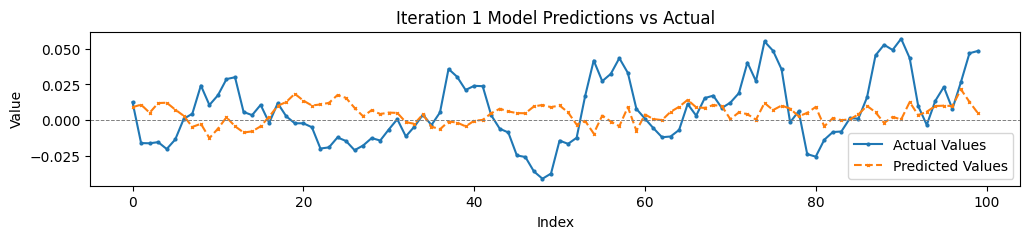

Deviations:
0.02260, 0.00663
Results: RMSE=0.029596, Std Dev=0.028580, Difference=0.023411

Iteration 2:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=2, pool_size=2, dense_units=100, dense_activation=tanh, activation=relu, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring model

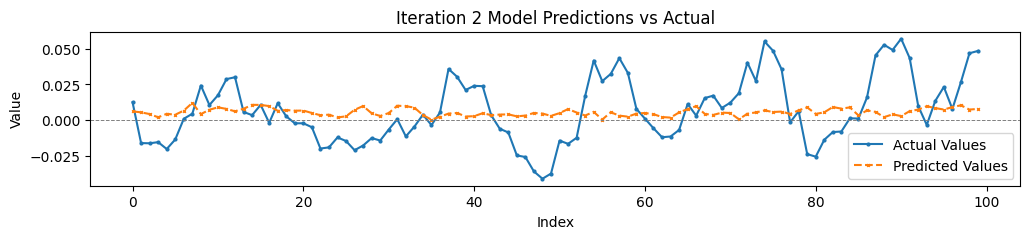

Deviations:
0.02260, 0.00257
Results: RMSE=0.029418, Std Dev=0.028580, Difference=0.025344

Iteration 3:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=2, pool_size=2, dense_units=100, dense_activation=relu, activation=tanh, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring model

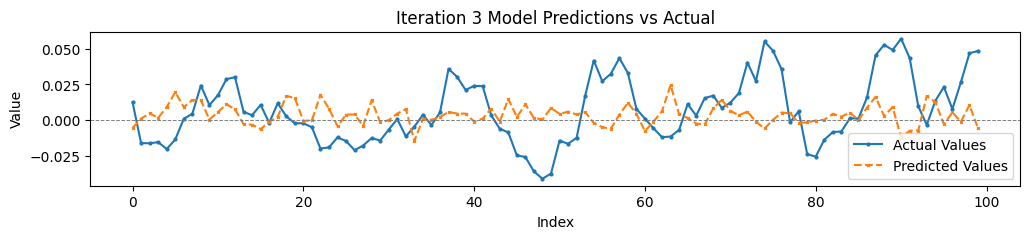

Deviations:
0.02260, 0.00705
Results: RMSE=0.030790, Std Dev=0.028580, Difference=0.020663

Iteration 4:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=2, pool_size=2, dense_units=100, dense_activation=relu, activation=relu, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring model

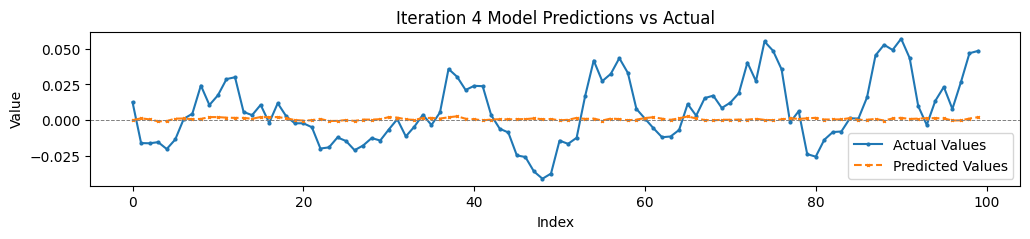

Deviations:
0.02260, 0.00077
Results: RMSE=0.028854, Std Dev=0.028580, Difference=0.026998

Iteration 5:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=2, pool_size=3, dense_units=100, dense_activation=tanh, activation=tanh, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring model

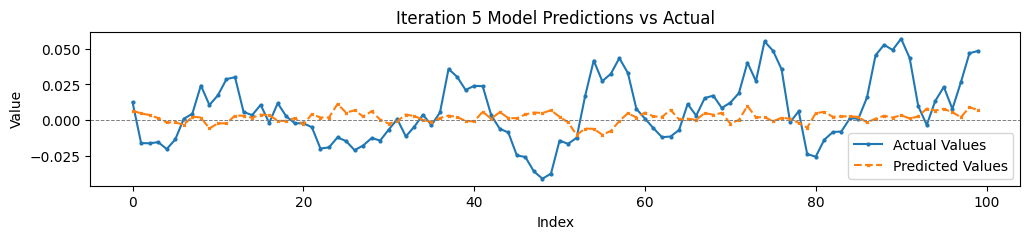

Deviations:
0.02260, 0.00390
Results: RMSE=0.029062, Std Dev=0.028580, Difference=0.025249

Iteration 6:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=2, pool_size=3, dense_units=100, dense_activation=tanh, activation=relu, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring model

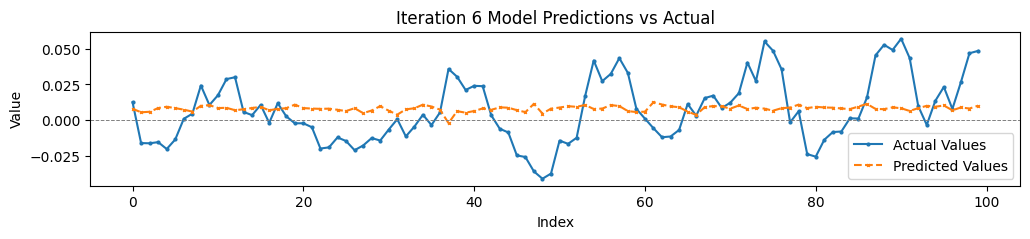

Deviations:
0.02260, 0.00198
Results: RMSE=0.029766, Std Dev=0.028580, Difference=0.026787

Iteration 7:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=2, pool_size=3, dense_units=100, dense_activation=relu, activation=tanh, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring model

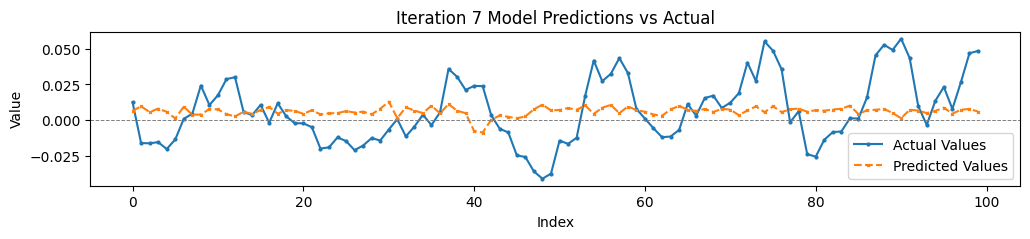

Deviations:
0.02260, 0.00316
Results: RMSE=0.029658, Std Dev=0.028580, Difference=0.025979

Iteration 8:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=2, pool_size=3, dense_units=100, dense_activation=relu, activation=relu, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring model

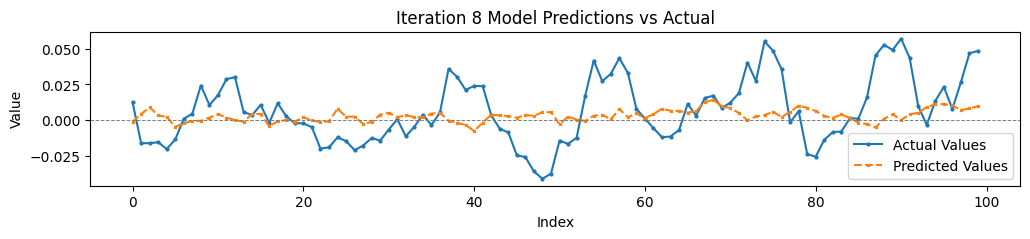

Deviations:
0.02260, 0.00412
Results: RMSE=0.029241, Std Dev=0.028580, Difference=0.024188

Iteration 9:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=2, pool_size=4, dense_units=100, dense_activation=tanh, activation=tanh, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring model

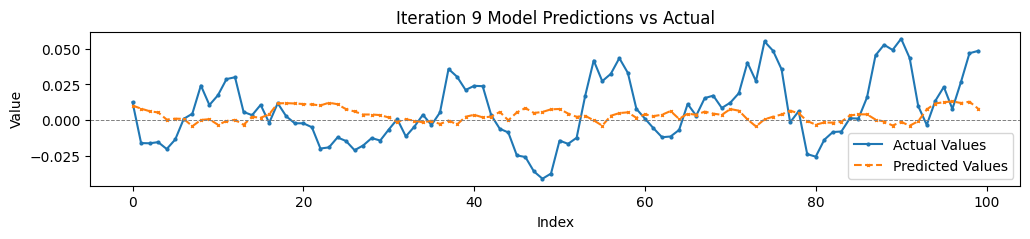

Deviations:
0.02260, 0.00459
Results: RMSE=0.029492, Std Dev=0.028580, Difference=0.024827

Iteration 10:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=2, pool_size=4, dense_units=100, dense_activation=tanh, activation=relu, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring mode

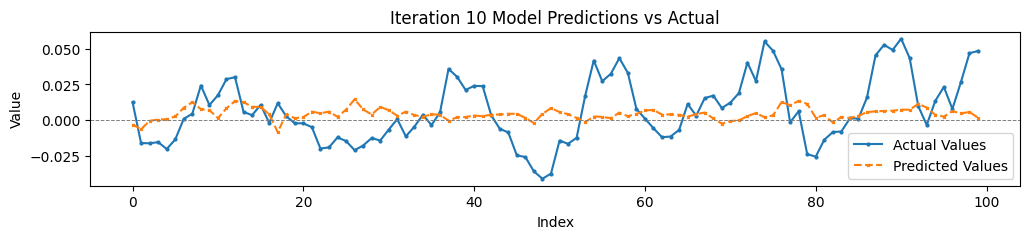

Deviations:
0.02260, 0.00403
Results: RMSE=0.029499, Std Dev=0.028580, Difference=0.025949

Iteration 11:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=2, pool_size=4, dense_units=100, dense_activation=relu, activation=tanh, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring mode

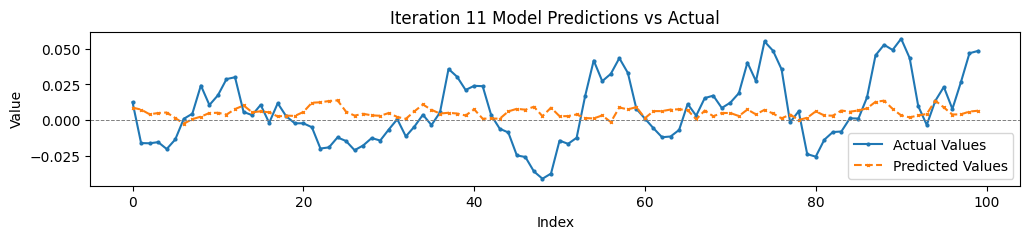

Deviations:
0.02260, 0.00337
Results: RMSE=0.029749, Std Dev=0.028580, Difference=0.025405

Iteration 12:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=2, pool_size=4, dense_units=100, dense_activation=relu, activation=relu, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring mode

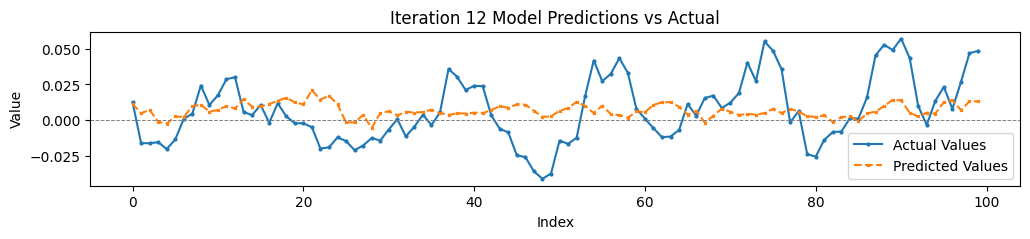

Deviations:
0.02260, 0.00469
Results: RMSE=0.031077, Std Dev=0.028580, Difference=0.024988

Iteration 13:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=3, pool_size=2, dense_units=100, dense_activation=tanh, activation=tanh, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring mode

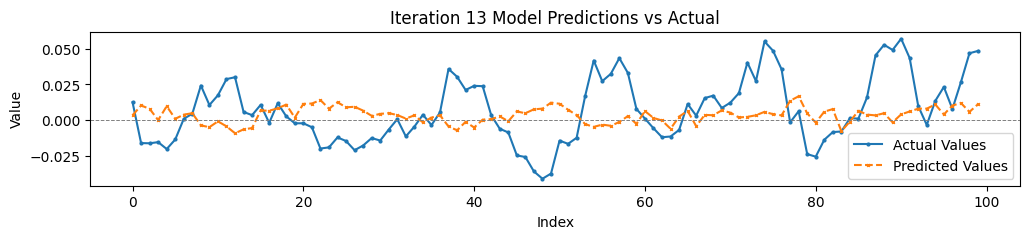

Deviations:
0.02260, 0.00550
Results: RMSE=0.029251, Std Dev=0.028580, Difference=0.024006

Iteration 14:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=3, pool_size=2, dense_units=100, dense_activation=tanh, activation=relu, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring mode

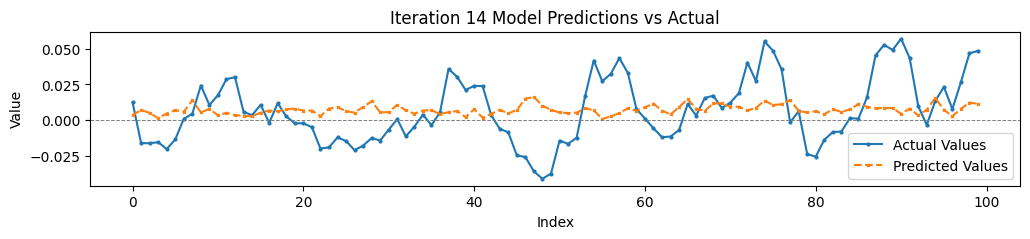

Deviations:
0.02260, 0.00326
Results: RMSE=0.029329, Std Dev=0.028580, Difference=0.025285

Iteration 15:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=3, pool_size=2, dense_units=100, dense_activation=relu, activation=tanh, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring mode

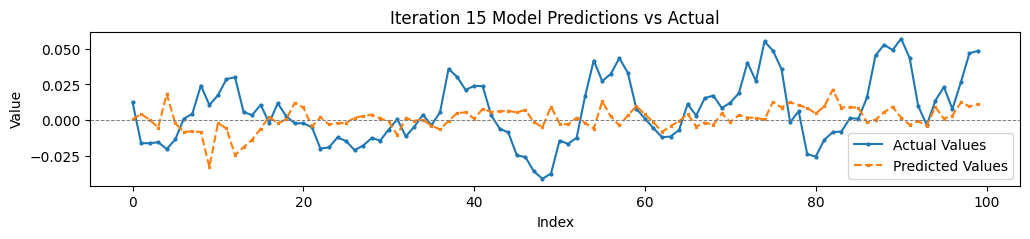

Deviations:
0.02260, 0.00791
Results: RMSE=0.030421, Std Dev=0.028580, Difference=0.021213

Iteration 16:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=3, pool_size=2, dense_units=100, dense_activation=relu, activation=relu, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring mode

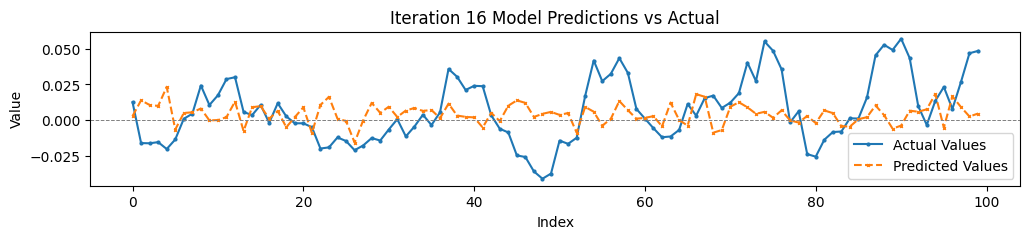

Deviations:
0.02260, 0.00693
Results: RMSE=0.032665, Std Dev=0.028580, Difference=0.022816

Iteration 17:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=3, pool_size=3, dense_units=100, dense_activation=tanh, activation=tanh, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring mode

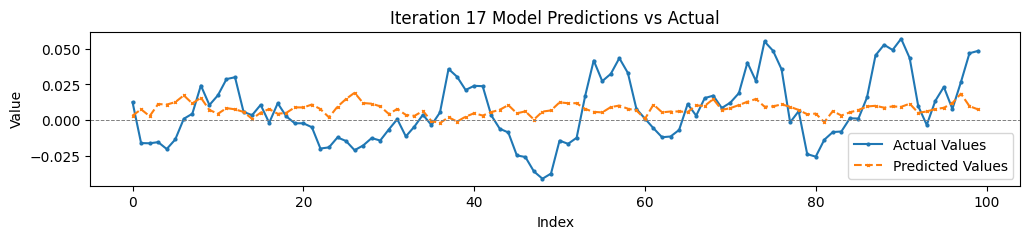

Deviations:
0.02260, 0.00414
Results: RMSE=0.029654, Std Dev=0.028580, Difference=0.024994

Iteration 18:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=3, pool_size=3, dense_units=100, dense_activation=tanh, activation=relu, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring mode

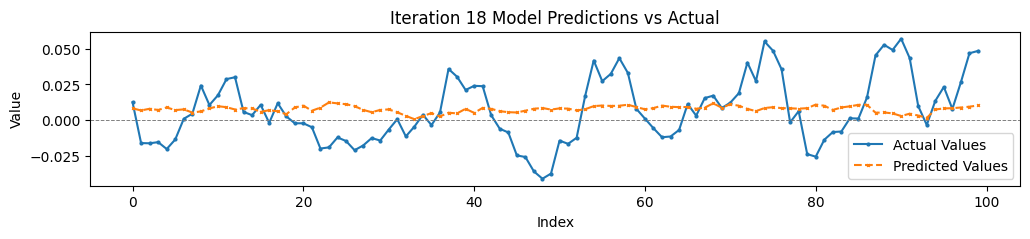

Deviations:
0.02260, 0.00231
Results: RMSE=0.029490, Std Dev=0.028580, Difference=0.026011

Iteration 19:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=3, pool_size=3, dense_units=100, dense_activation=relu, activation=tanh, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring mode

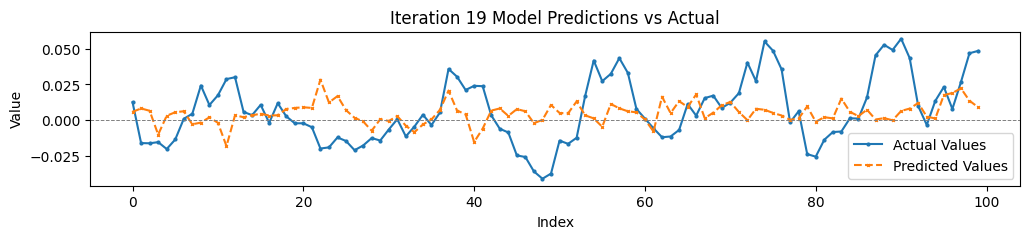

Deviations:
0.02260, 0.00733
Results: RMSE=0.029782, Std Dev=0.028580, Difference=0.021304

Iteration 20:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=3, pool_size=3, dense_units=100, dense_activation=relu, activation=relu, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring mode

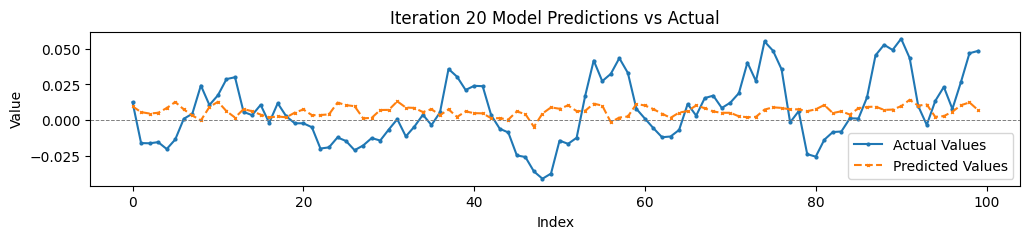

Deviations:
0.02260, 0.00355
Results: RMSE=0.029305, Std Dev=0.028580, Difference=0.023613

Iteration 21:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=3, pool_size=4, dense_units=100, dense_activation=tanh, activation=tanh, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring mode

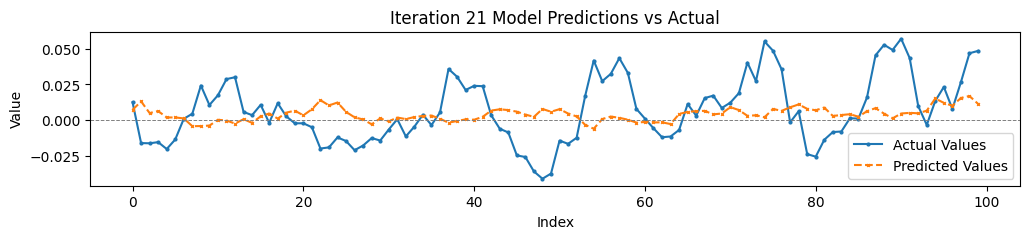

Deviations:
0.02260, 0.00463
Results: RMSE=0.029326, Std Dev=0.028580, Difference=0.024522

Iteration 22:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=3, pool_size=4, dense_units=100, dense_activation=tanh, activation=relu, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring mode

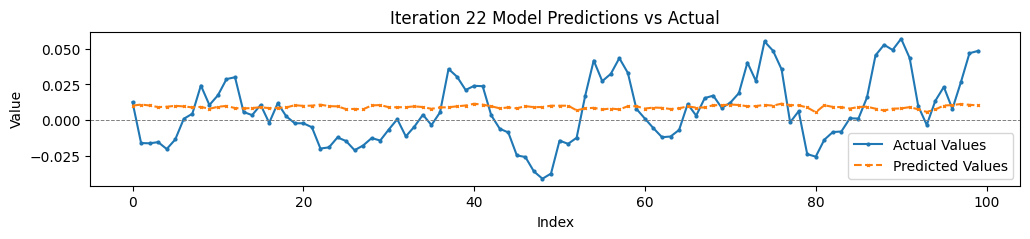

Deviations:
0.02260, 0.00118
Results: RMSE=0.030304, Std Dev=0.028580, Difference=0.028845

Iteration 23:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=3, pool_size=4, dense_units=100, dense_activation=relu, activation=tanh, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring mode

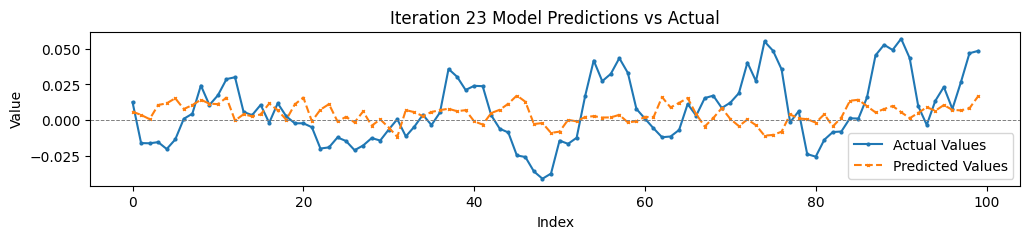

Deviations:
0.02260, 0.00659
Results: RMSE=0.030514, Std Dev=0.028580, Difference=0.024127

Iteration 24:
Configuration: n_steps=100, batch_size=16, epochs=100, filters=256
Model Parameters: filters=256, kernel_size=3, pool_size=4, dense_units=100, dense_activation=relu, activation=relu, dropout=0.15
   LMCADS03    LMCADY       SPX      MXWD       XAU       XAG    ACU_5D  \
0  0.010936  0.011509  0.019211  0.014910 -0.002492 -0.002064  0.040542   
1 -0.010936 -0.011664 -0.000011  0.002825  0.005654  0.004741  0.015400   
2  0.007000  0.006463 -0.001413  0.000755 -0.000564 -0.006809  0.011601   
3  0.011160  0.010982  0.005813  0.007021 -0.009067 -0.014599  0.027062   
4  0.006577  0.006050 -0.014531 -0.010854 -0.001709  0.001050  0.023340   

     ACU_4D    ACU_3D    ACU_2D  
0  0.027064  0.016802  0.021281  
1  0.005138  0.009617 -0.000154  
2  0.016080  0.006308 -0.005201  
3  0.017291  0.005781  0.017445  
4  0.011831  0.023495  0.017032  
Model input shape: (100, 10)
Restoring mode

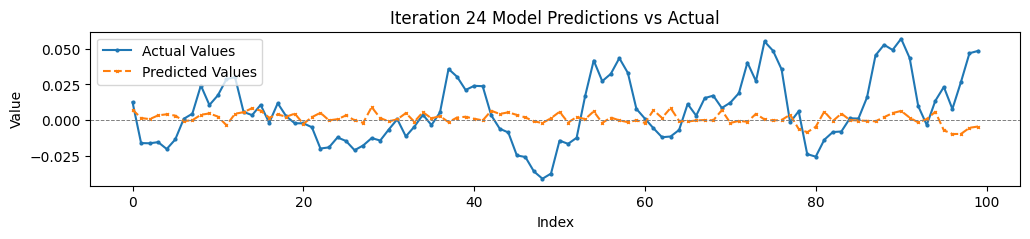

Deviations:
0.02260, 0.00378
Results: RMSE=0.029204, Std Dev=0.028580, Difference=0.024512


In [19]:
top_3_results = run_model_iterations()


Top 1 Model
Best RMSE: 0.030790 vs. a std of 0.028580, diff = 0.020663
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'tanh', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


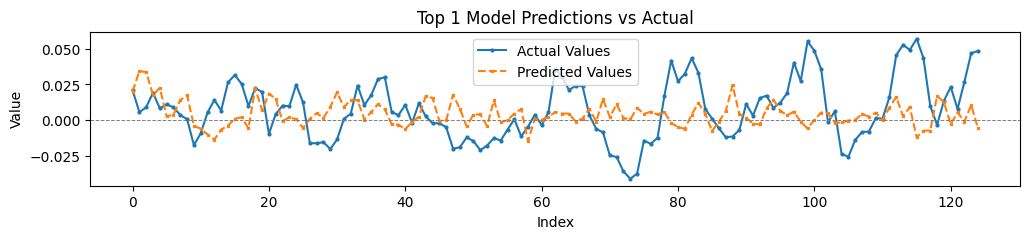

Deviations:
0.02093, 0.00873

Top 2 Model
Best RMSE: 0.030421 vs. a std of 0.028580, diff = 0.021213
Model parameters: {'filters': 256, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'tanh', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


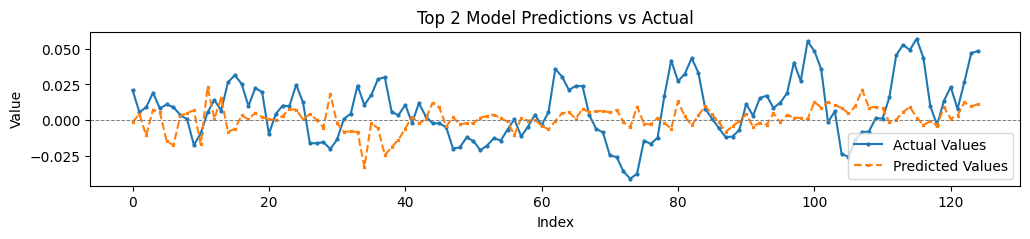

Deviations:
0.02093, 0.00819

Top 3 Model
Best RMSE: 0.029782 vs. a std of 0.028580, diff = 0.021304
Model parameters: {'filters': 256, 'kernel_size': 3, 'pool_size': 3, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'tanh', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


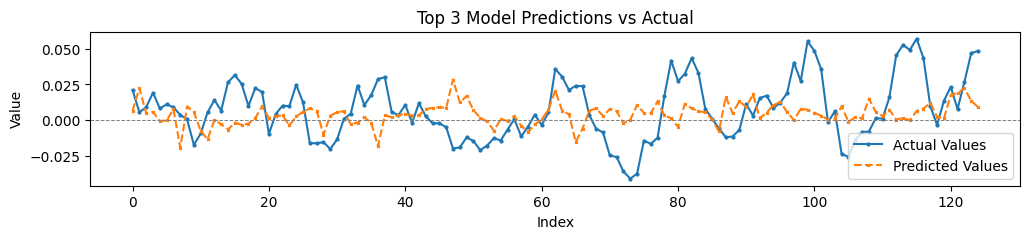

Deviations:
0.02093, 0.00763

Top 4 Model
Best RMSE: 0.032665 vs. a std of 0.028580, diff = 0.022816
Model parameters: {'filters': 256, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


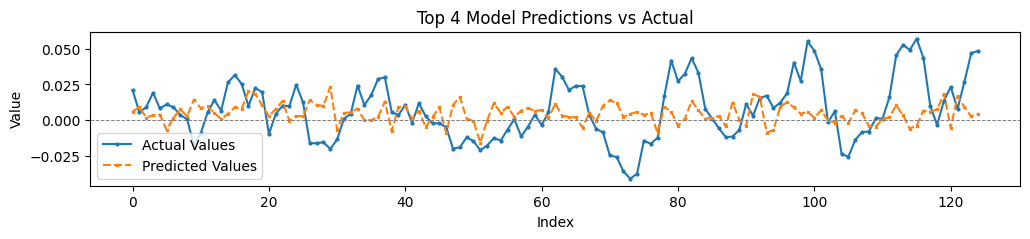

Deviations:
0.02093, 0.00679

Top 5 Model
Best RMSE: 0.029596 vs. a std of 0.028580, diff = 0.023411
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


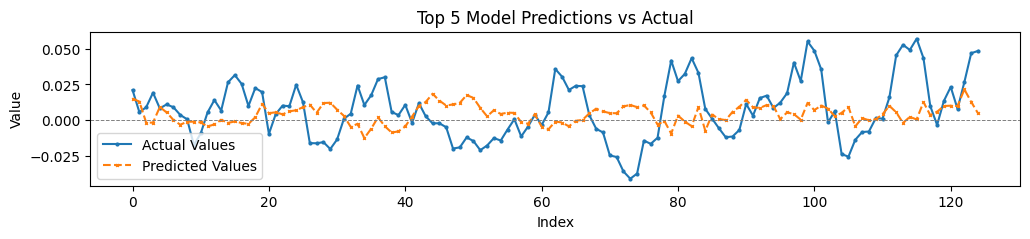

Deviations:
0.02093, 0.00646

Top 6 Model
Best RMSE: 0.029305 vs. a std of 0.028580, diff = 0.023613
Model parameters: {'filters': 256, 'kernel_size': 3, 'pool_size': 3, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


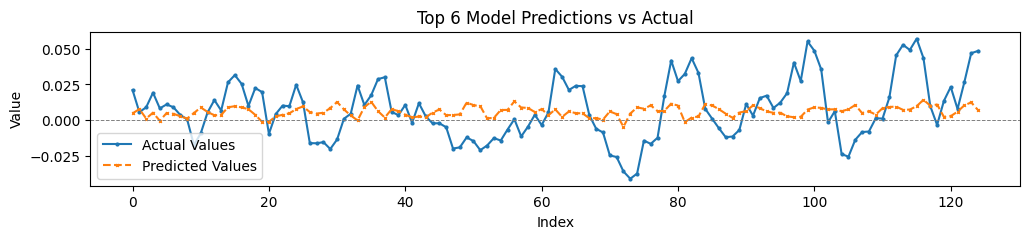

Deviations:
0.02093, 0.00354

Top 7 Model
Best RMSE: 0.029251 vs. a std of 0.028580, diff = 0.024006
Model parameters: {'filters': 256, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


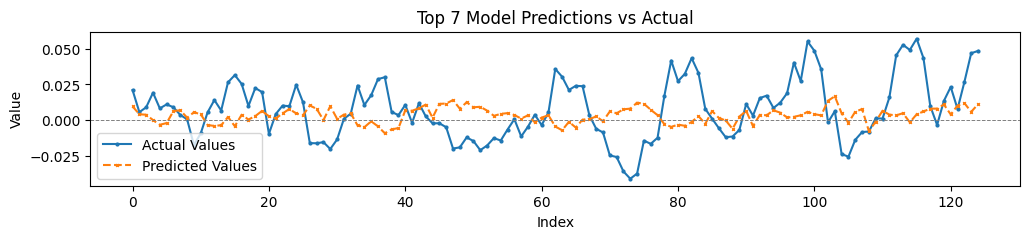

Deviations:
0.02093, 0.00525

Top 8 Model
Best RMSE: 0.030514 vs. a std of 0.028580, diff = 0.024127
Model parameters: {'filters': 256, 'kernel_size': 3, 'pool_size': 4, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'tanh', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


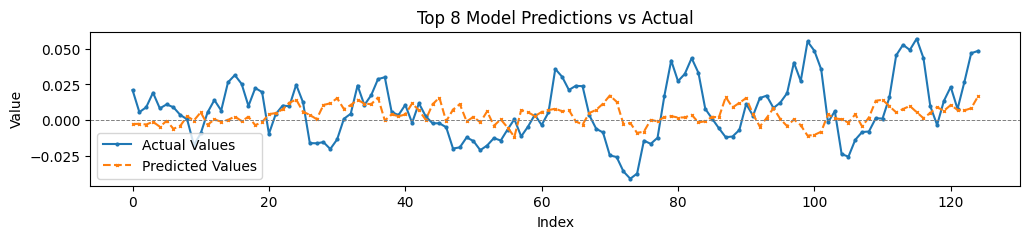

Deviations:
0.02093, 0.00646

Top 9 Model
Best RMSE: 0.029241 vs. a std of 0.028580, diff = 0.024188
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 3, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


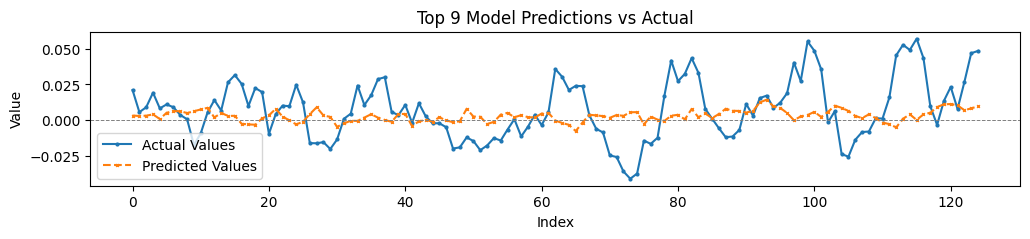

Deviations:
0.02093, 0.00398

Top 10 Model
Best RMSE: 0.029204 vs. a std of 0.028580, diff = 0.024512
Model parameters: {'filters': 256, 'kernel_size': 3, 'pool_size': 4, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


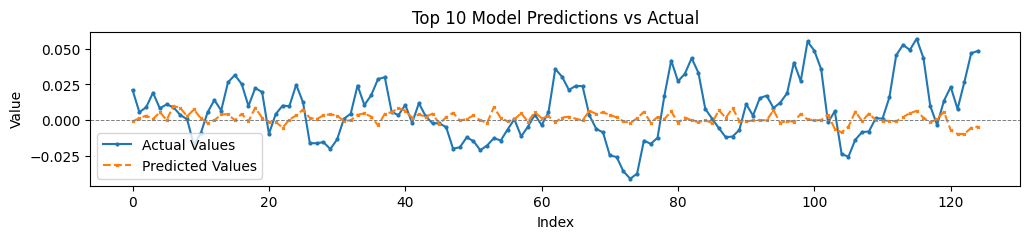

Deviations:
0.02093, 0.00378

Top 11 Model
Best RMSE: 0.029326 vs. a std of 0.028580, diff = 0.024522
Model parameters: {'filters': 256, 'kernel_size': 3, 'pool_size': 4, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


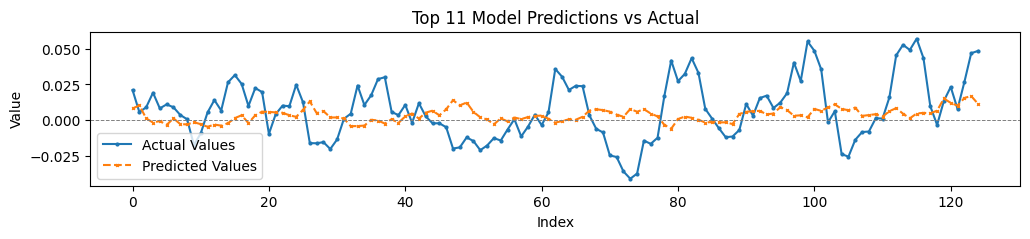

Deviations:
0.02093, 0.00469

Top 12 Model
Best RMSE: 0.029492 vs. a std of 0.028580, diff = 0.024827
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 4, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


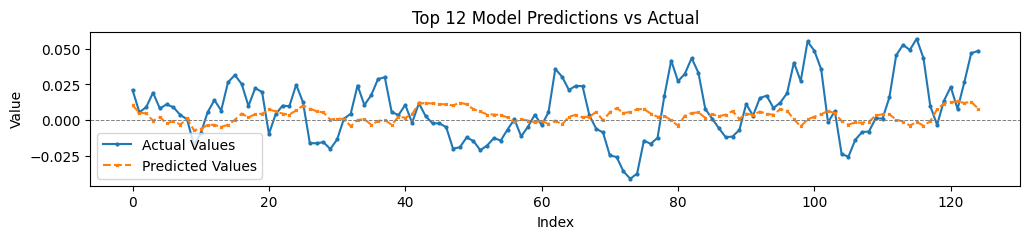

Deviations:
0.02093, 0.00467

Top 13 Model
Best RMSE: 0.031077 vs. a std of 0.028580, diff = 0.024988
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 4, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


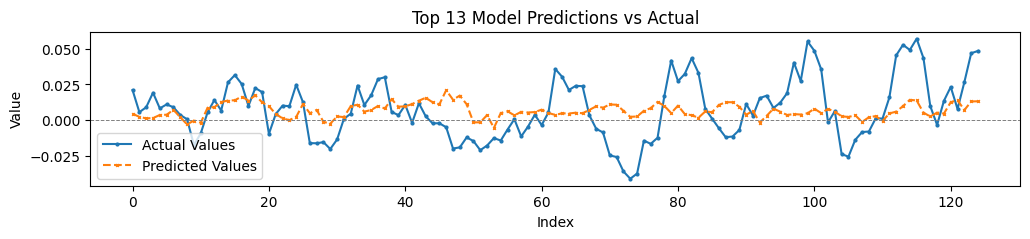

Deviations:
0.02093, 0.00498

Top 14 Model
Best RMSE: 0.029654 vs. a std of 0.028580, diff = 0.024994
Model parameters: {'filters': 256, 'kernel_size': 3, 'pool_size': 3, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


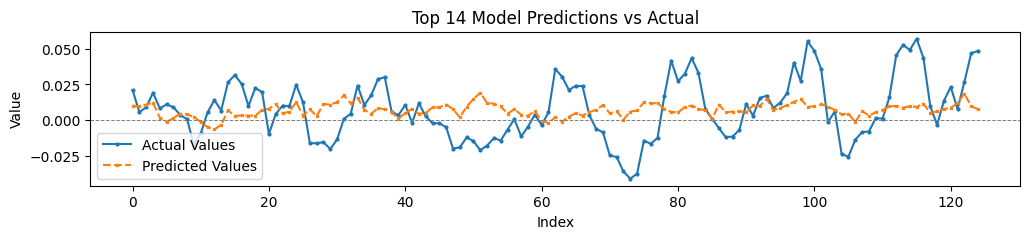

Deviations:
0.02093, 0.00457

Top 15 Model
Best RMSE: 0.029062 vs. a std of 0.028580, diff = 0.025249
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 3, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'tanh', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


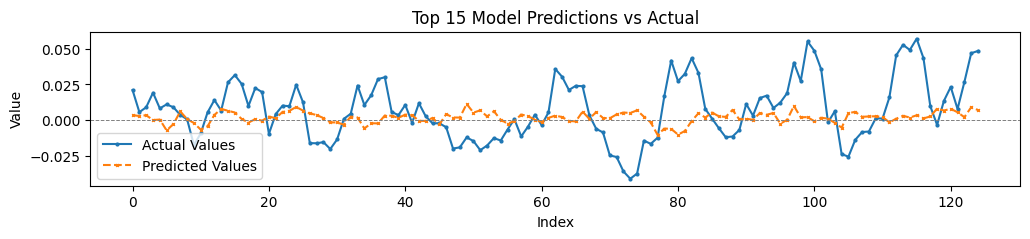

Deviations:
0.02093, 0.00397

Top 16 Model
Best RMSE: 0.029329 vs. a std of 0.028580, diff = 0.025285
Model parameters: {'filters': 256, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'relu', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


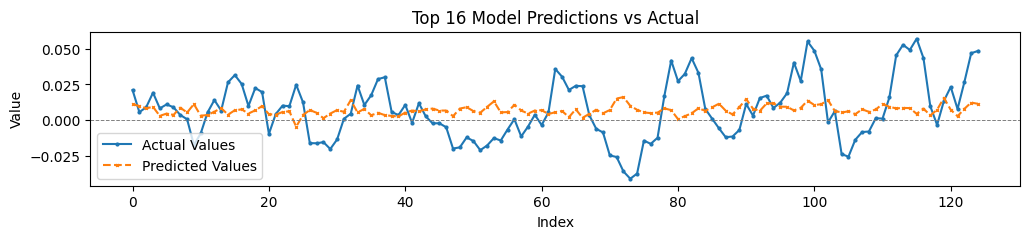

Deviations:
0.02093, 0.00331

Top 17 Model
Best RMSE: 0.029418 vs. a std of 0.028580, diff = 0.025344
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'relu', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


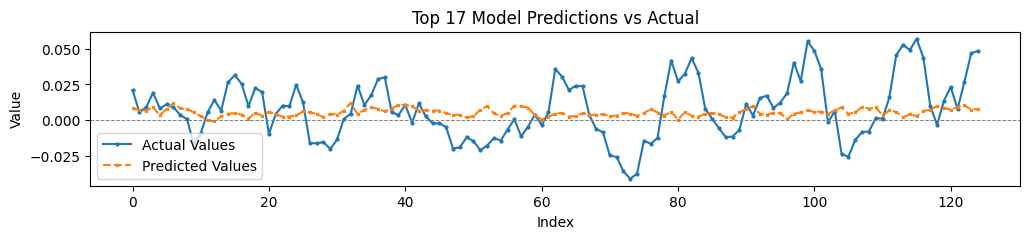

Deviations:
0.02093, 0.00267

Top 18 Model
Best RMSE: 0.029749 vs. a std of 0.028580, diff = 0.025405
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 4, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'tanh', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


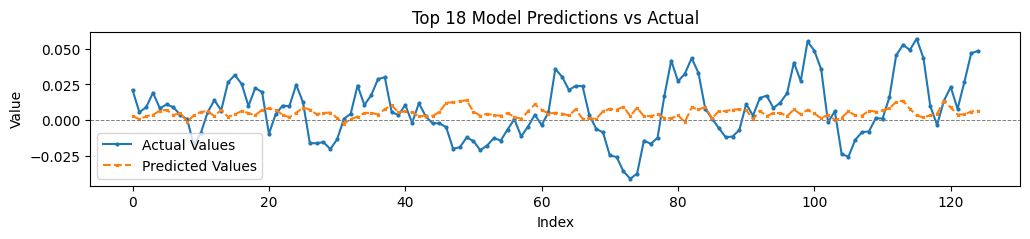

Deviations:
0.02093, 0.00320

Top 19 Model
Best RMSE: 0.029499 vs. a std of 0.028580, diff = 0.025949
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 4, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'relu', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


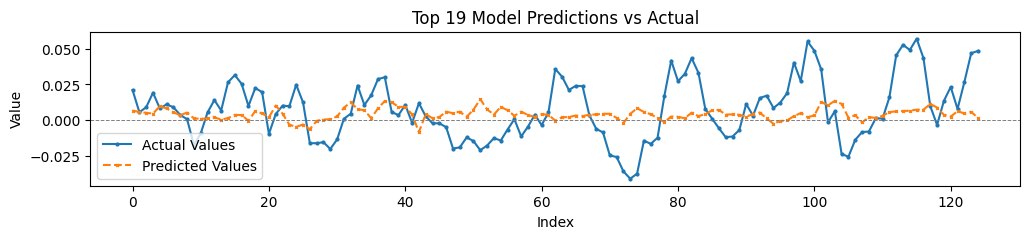

Deviations:
0.02093, 0.00395

Top 20 Model
Best RMSE: 0.029658 vs. a std of 0.028580, diff = 0.025979
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 3, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'tanh', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


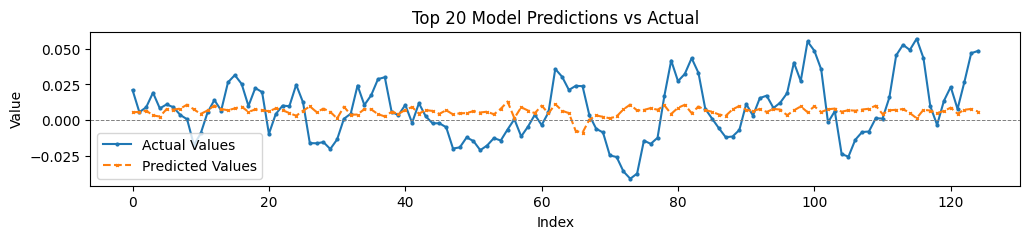

Deviations:
0.02093, 0.00298

Top 21 Model
Best RMSE: 0.029490 vs. a std of 0.028580, diff = 0.026011
Model parameters: {'filters': 256, 'kernel_size': 3, 'pool_size': 3, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'relu', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


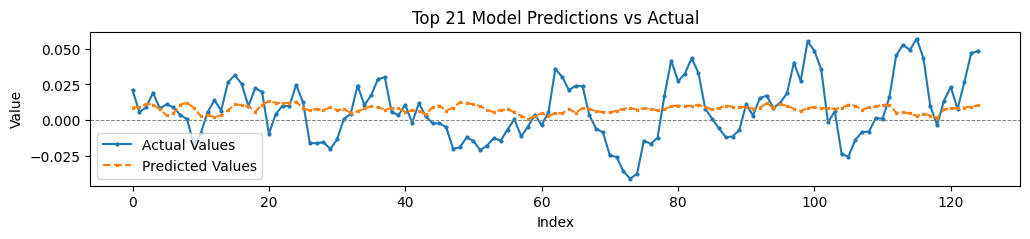

Deviations:
0.02093, 0.00263

Top 22 Model
Best RMSE: 0.029766 vs. a std of 0.028580, diff = 0.026787
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 3, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'relu', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


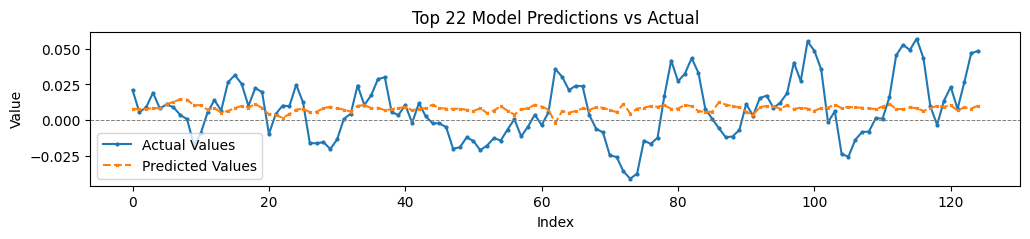

Deviations:
0.02093, 0.00225

Top 23 Model
Best RMSE: 0.028854 vs. a std of 0.028580, diff = 0.026998
Model parameters: {'filters': 256, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


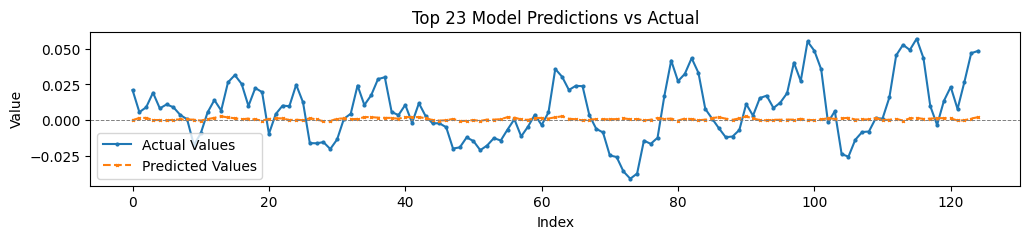

Deviations:
0.02093, 0.00077

Top 24 Model
Best RMSE: 0.030304 vs. a std of 0.028580, diff = 0.028845
Model parameters: {'filters': 256, 'kernel_size': 3, 'pool_size': 4, 'dense_units': 100, 'dense_activation': 'tanh', 'activation': 'relu', 'dropout': 0.15}
Features: ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAU', 'XAG', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
n_steps: 100, batch_size: 16


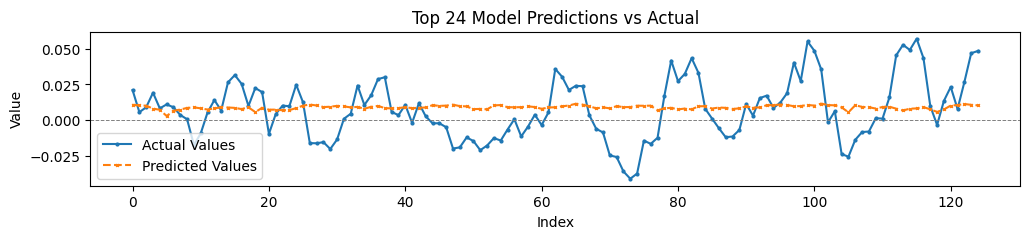

Deviations:
0.02093, 0.00136


In [20]:
for i, result in enumerate(top_3_results, 1):
    rmse            = result['rmse']
    model_params    = result['params']
    history         = result['history']
    batch_size      = result['batch_size']
    n_steps         = result['n_steps']
    y_test          = result['actuals']
    y_pred          = result['predictions']
    feature_list    = result['feature_list']
    diff = result['difference']

    print(f"\nTop {i} Model")
    print(f"Best RMSE: {rmse:.6f} vs. a std of {y_test.std():.6f}, diff = {diff:.6f}")
    print(f"Model parameters: {model_params}")
    print(f"Features: {feature_list}")
    print(f"n_steps: {n_steps}, batch_size: {batch_size}")

    plot_predictions(y_test, y_pred, 125, title=f"Top {i} Model Predictions vs Actual")

In [21]:
"""
n_steps_options     = [15]
batch_size_options  = [16]
epochs_options      = [100]

filters_options         = [64, 128, 256]
kernel_size_options     = [2, 3, 5]
pool_size_options       = [1, 2]
dense_units_options     = [50, 100, 150]
# dense_activation_options = ['relu', 'tanh']
dense_activation_options = ['relu']
# activation_options      = ['relu', 'tanh']
activation_options      = ['relu']
dropout_options         = [0.1, 0.2, 0.3]
"""

"\nn_steps_options     = [15]\nbatch_size_options  = [16]\nepochs_options      = [100]\n\nfilters_options         = [64, 128, 256]\nkernel_size_options     = [2, 3, 5]\npool_size_options       = [1, 2]\ndense_units_options     = [50, 100, 150]\n# dense_activation_options = ['relu', 'tanh']\ndense_activation_options = ['relu']\n# activation_options      = ['relu', 'tanh']\nactivation_options      = ['relu']\ndropout_options         = [0.1, 0.2, 0.3]\n"